In [42]:
from config import BASE_PATH, \
    DATASET_PATH, \
    NUM_LABEL, \
    MODEL_PATH, \
    INPUT_SHAPE_MODEL_V1, \
    INPUT_SHAPE_MODEL_V2, \
    INPUT_SHAPE_MODEL_V3, \
    INPUT_SHAPE_MODEL_V4, \
    BATCH_SIZE, \
    TRAIN_PROPORTION, \
    OPTIMIZER, \
    LOSS, \
    METRICS, \
    EN_NLP, \
    EN_SW, \
    JP_NLP

from Src import DatasetSplitter, SpamLDetectionModel
from Src import evaluate_model, minmax_scaling_tf, message_length, num_capitals, num_punctuation, word_counts_v1, word_counts_v2, word_counts_no_punct

from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from imblearn.over_sampling import SMOTE

import os 
import sklearn
import imblearn
import matplotlib
import unicodedata
import spacy

import tensorflow as tf 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stopwordsiso as sw

print(f'stopwordsiso version: {sw.__version__}')
print(f'tensorflow version: {tf.__version__}')
print(f'sklearn version: {sklearn.__version__}')
print(f'imblearn version: {imblearn.__version__}')
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'seaborn version: {sns.__version__}')
print(f'spacy version: {spacy.__version__}')

stopwordsiso version: 0.6.1
tensorflow version: 2.17.0
sklearn version: 1.5.1
imblearn version: 0.12.3
numpy version: 1.26.2
pandas version: 2.1.3
matplotlib version: 3.9.0
seaborn version: 0.13.2
spacy version: 3.7.5


In [43]:
df = pd.read_csv(DATASET_PATH, sep='\t', names=['label', 'message'])

In [44]:
df[:5]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Tokenisasi dalam Pemrosesan Bahasa Alami

Tokenisasi adalah langkah awal dalam pemrosesan bahasa alami (Natural Language Processing atau NLP). Proses ini mengubah teks menjadi daftar token. Token adalah unit dasar dari teks yang bisa berupa kata, karakter, atau bahkan kalimat. Mari kita bahas lebih detail dengan cara yang mudah dipahami.

#### Apa Itu Tokenisasi?

Bayangkan kamu punya sebuah kalimat: "Saya suka belajar NLP." Untuk memproses kalimat ini, komputer perlu memecahnya menjadi bagian-bagian yang lebih kecil yang disebut token. Ada beberapa cara untuk melakukan ini:

1. **Tokenisasi Kata**: Memecah kalimat menjadi kata-kata terpisah.
   - Contoh: "Saya suka belajar NLP." menjadi ["Saya", "suka", "belajar", "NLP"]

2. **Tokenisasi Karakter**: Memecah kalimat menjadi karakter-karakter terpisah.
   - Contoh: "Saya suka belajar NLP." menjadi ["S", "a", "y", "a", " ", "s", "u", "k", "a", " ", "b", "e", "l", "a", "j", "a", "r", " ", "N", "L", "P"]

#### Mengapa Tokenisasi Penting?

Tokenisasi penting karena membantu komputer memahami dan memproses teks dengan lebih baik. Dengan memecah teks menjadi bagian-bagian kecil, komputer bisa menganalisis dan bekerja dengan setiap bagian secara lebih efisien.

#### Tantangan dalam Tokenisasi

Tokenisasi bisa menjadi rumit, terutama dalam bahasa seperti Jepang dan Mandarin. Dalam bahasa-bahasa ini, tidak ada spasi antara kata-kata, sehingga sulit untuk menentukan di mana satu kata berakhir dan kata berikutnya dimulai.

#### Contoh Visual

Bayangkan kamu punya kalimat: 
"Belajar NLP itu menyenangkan."

- **Tokenisasi Kata**: ["Belajar", "NLP", "itu", "menyenangkan"]
- **Tokenisasi Karakter**: ["B", "e", "l", "a", "j", "a", "r", " ", "N", "L", "P", " ", "i", "t", "u", " ", "m", "e", "n", "y", "e", "n", "a", "n","g","k","a","n"]

Dengan memahami tokenisasi, kamu sudah mengambil langkah pertama dalam memahami bagaimana komputer memproses bahasa manusia!

### Segmentasi dalam Bahasa Jepang

Segmentasi adalah proses memisahkan teks menjadi unit-unit yang lebih kecil, seperti kata atau frasa. Dalam banyak bahasa, pemisahan ini dilakukan dengan menggunakan spasi. Namun, dalam bahasa seperti Jepang dan Mandarin, tidak ada pemisah antar kata, sehingga proses ini menjadi lebih rumit dan disebut segmentasi.

#### Karakter dalam Bahasa Jepang

Bahasa Jepang menggunakan tiga jenis karakter utama:
1. **Hiragana**: Digunakan untuk elemen gramatikal dan kata-kata asli Jepang.
2. **Kanji**: Diadaptasi dari karakter Tiongkok dan terdiri dari ribuan karakter.
3. **Katakana**: Digunakan terutama untuk kata-kata asing dan nama.

#### Tantangan Segmentasi

Karena tidak ada spasi antar kata, menentukan di mana satu kata berakhir dan kata berikutnya dimulai bisa sangat sulit. Misalnya, sebuah karakter bisa menjadi bagian dari kata yang sudah ada atau awal dari kata baru, tergantung pada karakter sebelumnya.

#### Contoh Segmentasi

Mari kita lihat contoh kata majemuk dalam bahasa Jepang yang berarti "Komite Administrasi Pemilihan" ((選挙管理委員会)):
- **Segmentasi 1**: 選挙 (Pemilihan) / 管理 (Administrasi) / 委員会 (Komite)
- **Segmentasi 2**: 選挙 (Pemilihan) / 管理 (Administrasi) / 委員会 (Komite) /会議 (Pertemuan)

#### Alat Segmentasi

Ada beberapa perpustakaan yang digunakan khusus untuk segmentasi atau tokenisasi bahasa Jepang:
- **MeCab**
- **Juman**
- **Sudachi**
- **Kuromoji**

MeCab sering digunakan dalam berbagai perpustakaan NLP seperti Hugging Face dan spaCy.

#### Mengapa Segmentasi Penting?

Segmentasi penting karena membantu komputer memahami teks dalam bahasa yang tidak memiliki pemisah antar kata. Dengan segmentasi yang tepat, komputer dapat menganalisis teks dengan lebih akurat dan efisien.

---
#### Untungnya, sebagian besar bahasa tidak serumit bahasa Jepang dan menggunakan spasi untuk memisahkan kata. Dalam Python, pemisahan dengan spasi adalah hal yang sepele.  Mari kita ambil sebuah contoh:
---

In [45]:
sample_text = 'Go until jurong point, crazy.. Available only in bugis n great world'
sample_text.split(sep=' ')

['Go',
 'until',
 'jurong',
 'point,',
 'crazy..',
 'Available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world']

In [46]:
# spacy.cli.download("en_core_web_sm")

In [47]:
# Load English NLP pipeline
tokenized = EN_NLP(sample_text)

In [48]:
# Iterasi melalui kalimat dan kata-kata
count = 0
for sentence in tokenized.sents:
    for token in sentence:
        count += len(token)
        print(token)
    print("<End of Sentence>")
count

Go
until
jurong
point
,
crazy
..
<End of Sentence>
Available
only
in
bugis
n
great
world
<End of Sentence>


57

### Japanese Tokenization Example

In [49]:
# spacy.cli.download("ja_core_news_sm")

In [50]:
# Load English NLP pipeline
jp_text = "選挙管理委員会"
jp_tokenized = JP_NLP(jp_text)

In [51]:
for jp_sentence in jp_tokenized.sents:
    for jp_token in jp_sentence:
        print(jp_token)

選挙
管理
委員
会


### Adding Word Count Feature 

In [52]:
df[:5]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [53]:
df_copy = df.copy(deep=True)
lb = LabelBinarizer()

df_copy['label'] = lb.fit_transform(df_copy['label'])
df_copy['capitals'] = df_copy['message'].apply(num_capitals)
df_copy['punctuation'] = df_copy['message'].apply(num_punctuation)
df_copy['length'] = df_copy['message'].apply(message_length)
df_copy['words'] = df_copy['message'].apply(word_counts_v1)

In [54]:
df_copy[:5]

,label,message,capitals,punctuation,length,words
0,0,"Go until jurong point, crazy.. Available only ...",3,9,111,24
1,0,Ok lar... Joking wif u oni...,2,6,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,10,6,155,31
3,0,U dun say so early hor... U c already then say...,2,6,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",2,2,61,15


In [55]:
df_copy.describe()

,label,capitals,punctuation,length,words
count,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000
mean,0.134063,5.633345,4.139268,80.489950,18.748744
std,0.340751,11.711637,4.568942,59.942907,13.736345
min,0.000000,0.000000,0.000000,2.000000,1.000000
25%,0.000000,1.000000,2.000000,36.000000,9.000000
50%,0.000000,2.000000,3.000000,62.000000,15.000000
75%,0.000000,4.000000,6.000000,122.000000,27.000000
max,1.000000,138.000000,133.000000,910.000000,196.000000


In [56]:
lb.classes_

array(['ham', 'spam'], dtype='<U4')

In [57]:
print('Ham dataframe statistic')
df_copy[df_copy['label'] == 0].describe()

Ham dataframe statistic


,label,capitals,punctuation,length,words
count,4825.0,4825.000000,4825.000000,4825.000000,4825.000000
mean,0.0,4.110466,3.928705,71.482487,17.178653
std,0.0,10.848116,4.692083,58.440652,13.831520
min,0.0,0.000000,0.000000,2.000000,1.000000
25%,0.0,1.000000,1.000000,33.000000,8.000000
50%,0.0,2.000000,3.000000,52.000000,13.000000
75%,0.0,3.000000,5.000000,93.000000,22.000000
max,0.0,138.000000,133.000000,910.000000,196.000000


In [58]:
print('Spam dataframe statistic')
df_copy[df_copy['label'] == 1].describe()

Spam dataframe statistic


,label,capitals,punctuation,length,words
count,747.0,747.00000,747.000000,747.000000,747.000000
mean,1.0,15.46988,5.499331,138.670683,28.890228
std,0.0,12.30576,3.374870,28.873603,7.282963
min,1.0,0.00000,0.000000,13.000000,2.000000
25%,1.0,7.00000,3.000000,133.000000,26.000000
50%,1.0,14.00000,5.000000,149.000000,30.000000
75%,1.0,21.00000,8.000000,157.000000,34.000000
max,1.0,128.00000,25.000000,223.000000,49.000000


Analisis statistik dari pesan spam dan pesan reguler, dengan fokus pada beberapa fitur utama seperti penggunaan huruf kapital dan jumlah kata. Berikut adalah poin-poin penting yang diuraikan:

1. **Pola yang Terlihat**:
   - Pesan spam cenderung memiliki variasi yang lebih kecil dari rata-rata dibandingkan dengan pesan reguler.

2. **Penggunaan Huruf Kapital**:
   - Kolom fitur "Capitals" menunjukkan bahwa pesan reguler menggunakan lebih sedikit huruf kapital dibandingkan pesan spam.
   - Pada persentil ke-75, pesan reguler memiliki 3 huruf kapital, sedangkan pesan spam memiliki 21 huruf kapital.
   - Rata-rata, pesan reguler memiliki 4 huruf kapital, sementara pesan spam memiliki 15 huruf kapital.

3. **Jumlah Kata**:
   - Variasi dalam jumlah kata tidak terlalu mencolok.
   - Pesan reguler rata-rata memiliki 17 kata, sedangkan pesan spam memiliki 29 kata.
   - Pada persentil ke-75, pesan reguler memiliki 22 kata, sementara pesan spam memiliki 34 kata.

4. **Analisis Awal**:
   - Analisis awal ini menunjukkan mengapa menambahkan fitur jumlah kata tidak terlalu berguna dalam membedakan pesan spam dari pesan reguler.

5. **Pertimbangan Lain**:
   - Model tokenisasi memisahkan tanda baca sebagai kata. Idealnya, tanda baca ini harus dihapus dari jumlah kata karena fitur tanda baca menunjukkan bahwa pesan spam menggunakan lebih banyak karakter tanda baca.
   - Penghapusan kata umum (stop word removal) juga perlu dipertimbangkan. Ini adalah fokus dari bagian selanjutnya.

Secara keseluruhan, teks ini menjelaskan bagaimana fitur-fitur tertentu seperti penggunaan huruf kapital dan jumlah kata dapat digunakan untuk membedakan antara pesan spam dan pesan reguler, serta beberapa langkah tambahan yang perlu diambil untuk meningkatkan akurasi analisis.

In [59]:
df_copy['label'].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [60]:
X = df_copy.drop(columns=['label', 'message'])
y = df_copy['label']

# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [19]:
# X_resampled[:5]

In [20]:
# y_resampled[:5]

In [21]:
# y_resampled.value_counts()

In [24]:
SMSSpamCollection_tf_data = tf.data.Dataset.from_tensor_slices((X, y))

In [61]:
print(f'info train data: {SMSSpamCollection_tf_data}')
print(f'number of train data: {len(SMSSpamCollection_tf_data)}')

info train data: <_TensorSliceDataset element_spec=(TensorSpec(shape=(4,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of train data: 5572


In [62]:
for data, label in SMSSpamCollection_tf_data.skip(0).take(3):
    label_str = lb.inverse_transform(np.array(label))
    print(f'data: {data}')
    print(f'label: {label} --> {label_str[0]}')
    print()

data: [  3   9 111  24]
label: 0 --> ham

data: [ 2  6 29  8]
label: 0 --> ham

data: [ 10   6 155  31]
label: 1 --> spam



In [63]:
SMSSpamCollection_tf_data_scaled = SMSSpamCollection_tf_data.map( 
    map_func=lambda features, label: minmax_scaling_tf(features, label, feature_range=(0, 1)),
    num_parallel_calls=tf.data.AUTOTUNE
)
SMSSpamCollection_tf_data_cached = SMSSpamCollection_tf_data_scaled.cache()

In [64]:
print(f'info train data: {SMSSpamCollection_tf_data_cached}')
print(f'number of train data: {len(SMSSpamCollection_tf_data_cached)}')

info train data: <CacheDataset element_spec=(TensorSpec(shape=(4,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
number of train data: 5572


In [65]:
for data, label in SMSSpamCollection_tf_data_cached.skip(0).take(3):
    label_str = lb.inverse_transform(np.array(label))
    print(f'data: {data}')
    print(f'label: {label} --> {label_str[0]}')
    print()

data: [0.         0.05555556 1.         0.19444445]
label: 0 --> ham

data: [0.         0.14814815 1.         0.22222222]
label: 0 --> ham

data: [0.02684564 0.         1.         0.16778524]
label: 1 --> spam



In [66]:
splitter = DatasetSplitter(batch_size=BATCH_SIZE, train_split=TRAIN_PROPORTION)

In [67]:
SMSSpamCollection_tf_data_train, SMSSpamCollection_tf_data_valid = splitter.split_and_prepare(SMSSpamCollection_tf_data_cached)

=================================== Training Dataset ===================================
Info data: <_TakeDataset element_spec=(TensorSpec(shape=(4,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
Training Split: 0.8
Number of data: 4457
AFTER BATCH: 32
Number of data: 140
=================================== Validation Dataset ===================================
Info data: <_SkipDataset element_spec=(TensorSpec(shape=(4,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
Validation Split: 0.2
Number of data: 1115
AFTER BATCH: 32
Number of data: 35


In [70]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
my_model=SpamLDetectionModel(
    input_shape=INPUT_SHAPE_MODEL_V2, 
    num_classes=NUM_LABEL, 
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
)
my_model.model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73 (292.00 B)

 Trainable params: 73 (292.00 B)

 Non-trainable params: 0 (0.00 B)

In [71]:
history = my_model.train(
    SMSSpamCollection_tf_data_train,
    validation_data=SMSSpamCollection_tf_data_valid,
    epochs=30,
)

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4503 - loss: 0.6931 - val_accuracy: 0.8556 - val_loss: 0.4882
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8605 - loss: 0.4546 - val_accuracy: 0.8700 - val_loss: 0.3937
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8737 - loss: 0.3818 - val_accuracy: 0.8691 - val_loss: 0.3816
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8693 - loss: 0.3795 - val_accuracy: 0.8717 - val_loss: 0.3721
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8639 - loss: 0.3849 - val_accuracy: 0.8601 - val_loss: 0.3892
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8603 - loss: 0.3860 - val_accuracy: 0.8592 - val_loss: 0.3869
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8574 - loss: 0.3880 - val_accuracy: 0.8655 - val_loss: 0.3697
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.3625 - val_accuracy: 0.

In [72]:
# Evaluasi model yang dimuat
loaded_evaluation = my_model.model.evaluate(SMSSpamCollection_tf_data_valid)
print(f'Evaluation on validation data (loaded model): {loaded_evaluation}')

 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9062 - loss: 0.2433

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8815 - loss: 0.2736 
Evaluation on validation data (loaded model): [0.28024137020111084, 0.8807175159454346]


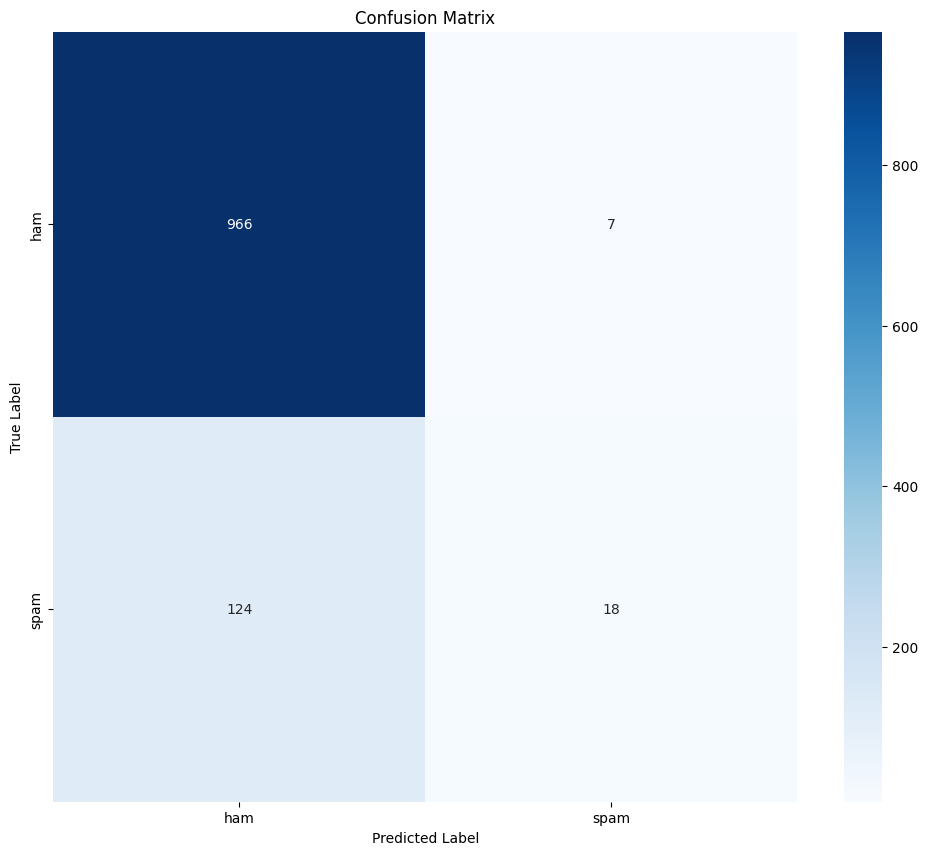

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94       973
         1.0       0.72      0.13      0.22       142

    accuracy                           0.88      1115
   macro avg       0.80      0.56      0.58      1115
weighted avg       0.87      0.88      0.84      1115



In [73]:
evaluate_model(my_model.model, SMSSpamCollection_tf_data_valid, lb.classes_)

---
#### Setelah melalui Tokenisasi model mengalami peningkatan akurasi, dengan menunjukkan bahwa 966 dari 973 pesan reguler (ham) diklasifikasikan dengan benar, sementara 18 dari 142 pesan spam diklasifikasikan dengan benar.
---

## Penghapusan Kata Umum (Stop Word Removal)

Penghapusan kata umum adalah proses menghilangkan kata-kata yang sering muncul dan tidak memberikan banyak informasi, seperti artikel (the, an) dan konjungsi (and, but). Dalam konteks pencarian informasi atau mesin pencari, kata-kata ini tidak membantu dalam menemukan dokumen atau halaman web yang relevan dengan kueri.

#### Contoh Penghapusan Kata Umum

Misalnya, dalam kueri "Where is Google based?" kata "is" adalah kata umum. Hasil pencarian akan tetap sama meskipun kata "is" dihapus. Untuk menentukan kata umum, kita bisa menggunakan petunjuk tata bahasa. Dalam bahasa Inggris, artikel dan konjungsi biasanya bisa dihapus.

#### Pendekatan yang Lebih Kuat

Pendekatan yang lebih kuat adalah dengan mempertimbangkan frekuensi kemunculan kata dalam korpus (kumpulan dokumen atau teks). Kata-kata yang paling sering muncul bisa dipilih sebagai kandidat untuk daftar kata umum. Namun, daftar ini sebaiknya ditinjau secara manual karena ada kasus di mana kata-kata yang sering muncul tetap memiliki makna penting. Misalnya, dalam dokumen dari Federal Reserve, kata "economy" mungkin sering muncul tetapi tetap penting dan tidak boleh dihapus.

#### Informasi dalam Kata Umum

Kadang-kadang, kata umum bisa mengandung informasi penting. Ini berlaku untuk frasa tertentu. Misalnya, dalam frasa "flights to Paris," kata "to" memberikan informasi berharga dan penghapusannya bisa mengubah makna frasa tersebut.

#### Tahapan Pemrosesan Teks

Setelah normalisasi teks, langkah berikutnya adalah vektorisasi. Langkah ini melibatkan pembuatan kosakata atau kamus dari semua token. Ukuran kosakata ini bisa dikurangi dengan menghapus kata umum. Saat melatih dan mengevaluasi model, penghapusan kata umum mengurangi jumlah langkah komputasi yang perlu dilakukan, sehingga meningkatkan kecepatan komputasi dan menghemat ruang penyimpanan.

#### Perkembangan Modern dalam NLP

Kemajuan modern dalam NLP melihat daftar kata umum yang semakin kecil karena skema pengkodean dan metode komputasi yang lebih efisien terus berkembang. Banyak paket NLP menyediakan daftar kata umum yang bisa dihapus setelah tokenisasi. Misalnya, NLTK dan spaCy menyediakan daftar kata umum untuk berbagai bahasa.

In [40]:
print(f'available languages: {len(sw.langs())}')

available languages: 58


The list of codes itself is from [www.loc.gov](http://www.loc.gov/standards/iso639-2/php/code_list.php).

| ISO 639-1 Code | Language | Included Here |
| -------------- | -------- | ------------- |
| aa | Afar |  |
| ab | Abkhazian |  |
| af | Afrikaans | ✓ |
| ak | Akan |  |
| sq | Albanian |  |
| am | Amharic |  |
| ar | Arabic | ✓ |
| an | Aragonese |  |
| hy | Armenian | ✓ |
| as | Assamese |  |
| av | Avaric |  |
| ae | Avestan |  |
| ay | Aymara |  |
| az | Azerbaijani |  |
| ba | Bashkir |  |
| bm | Bambara |  |
| eu | Basque | ✓ |
| be | Belarusian |  |
| bn | Bengali | ✓ |
| bh | Bihari languages |  |
| bi | Bislama |  |
| bo | Tibetan |  |
| bs | Bosnian |  |
| br | Breton | ✓ |
| bg | Bulgarian | ✓ |
| my | Burmese |  |
| ca | Catalan; Valencian | ✓ |
| cs | Czech | ✓ |
| ch | Chamorro |  |
| ce | Chechen |  |
| zh | Chinese | ✓ |
| cu | Church Slavic; Old Slavonic; Church Slavonic; Old Bulgarian; Old Church Slavonic |  |
| cv | Chuvash |  |
| kw | Cornish |  |
| co | Corsican |  |
| cr | Cree |  |
| cy | Welsh |  |
| da | Danish | ✓ |
| de | German | ✓ |
| dv | Divehi; Dhivehi; Maldivian |  |
| nl | Dutch; Flemish | ✓ |
| dz | Dzongkha |  |
| el | Greek, Modern (1453-) | ✓ |
| en | English | ✓ |
| eo | Esperanto | ✓ |
| et | Estonian | ✓ |
| ee | Ewe |  |
| fo | Faroese |  |
| fa | Persian | ✓ |
| fj | Fijian |  |
| fi | Finnish | ✓ |
| fr | French | ✓ |
| fy | Western Frisian |  |
| ff | Fulah |  |
| ka | Georgian |  |
| gd | Gaelic; Scottish Gaelic |  |
| ga | Irish | ✓ |
| gl | Galician | ✓ |
| gv | Manx |  |
| gn | Guarani |  |
| gu | Gujarati | ✓ |
| ht | Haitian; Haitian Creole |  |
| ha | Hausa | ✓ |
| he | Hebrew | ✓ |
| hz | Herero |  |
| hi | Hindi | ✓ |
| ho | Hiri Motu |  |
| hr | Croatian | ✓ |
| hu | Hungarian | ✓ |
| ig | Igbo |  |
| is | Icelandic |  |
| io | Ido |  |
| ii | Sichuan Yi; Nuosu |  |
| iu | Inuktitut |  |
| ie | Interlingue; Occidental |  |
| ia | Interlingua (International Auxiliary Language Association) |  |
| id | Indonesian | ✓ |
| ik | Inupiaq |  |
| it | Italian | ✓ |
| jv | Javanese |  |
| ja | Japanese | ✓ |
| kl | Kalaallisut; Greenlandic |  |
| kn | Kannada |  |
| ks | Kashmiri |  |
| kr | Kanuri |  |
| kk | Kazakh |  |
| km | Central Khmer |  |
| ki | Kikuyu; Gikuyu |  |
| rw | Kinyarwanda |  |
| ky | Kirghiz; Kyrgyz |  |
| kv | Komi |  |
| kg | Kongo |  |
| ko | Korean | ✓ |
| kj | Kuanyama; Kwanyama |  |
| ku | Kurdish | ✓ |
| lo | Lao |  |
| la | Latin | ✓ |
| lv | Latvian | ✓ |
| li | Limburgan; Limburger; Limburgish |  |
| ln | Lingala |  |
| lt | Lithuanian | ✓ |
| lb | Luxembourgish; Letzeburgesch |  |
| lu | Luba-Katanga |  |
| lg | Ganda |  |
| mk | Macedonian |  |
| mh | Marshallese |  |
| ml | Malayalam |  |
| mi | Maori |  |
| mr | Marathi | ✓ |
| ms | Malay | ✓ |
| mg | Malagasy |  |
| mt | Maltese |  |
| mn | Mongolian |  |
| na | Nauru |  |
| nv | Navajo; Navaho |  |
| nr | Ndebele, South; South Ndebele |  |
| nd | Ndebele, North; North Ndebele |  |
| ng | Ndonga |  |
| ne | Nepali |  |
| nn | Norwegian Nynorsk; Nynorsk, Norwegian |  |
| nb | Bokmål, Norwegian; Norwegian Bokmål |  |
| no | Norwegian | ✓ |
| ny | Chichewa; Chewa; Nyanja |  |
| oc | Occitan (post 1500) |  |
| oj | Ojibwa |  |
| or | Oriya |  |
| om | Oromo |  |
| os | Ossetian; Ossetic |  |
| pa | Panjabi; Punjabi |  |
| pi | Pali |  |
| pl | Polish | ✓ |
| pt | Portuguese | ✓ |
| ps | Pushto; Pashto |  |
| qu | Quechua |  |
| rm | Romansh |  |
| ro | Romanian; Moldavian; Moldovan | ✓ |
| rn | Rundi |  |
| ru | Russian | ✓ |
| sg | Sango |  |
| sa | Sanskrit |  |
| si | Sinhala; Sinhalese |  |
| sk | Slovak | ✓ |
| sl | Slovenian | ✓ |
| se | Northern Sami |  |
| sm | Samoan |  |
| sn | Shona |  |
| sd | Sindhi |  |
| so | Somali | ✓ |
| st | Sotho, Southern | ✓ |
| es | Spanish; Castilian | ✓ |
| sc | Sardinian |  |
| sr | Serbian |  |
| ss | Swati |  |
| su | Sundanese |  |
| sw | Swahili | ✓ |
| sv | Swedish | ✓ |
| ty | Tahitian |  |
| ta | Tamil |  |
| tt | Tatar |  |
| te | Telugu |  |
| tg | Tajik |  |
| tl | Tagalog | ✓ |
| th | Thai | ✓ |
| ti | Tigrinya |  |
| to | Tonga (Tonga Islands) |  |
| tn | Tswana |  |
| ts | Tsonga |  |
| tk | Turkmen |  |
| tr | Turkish | ✓ |
| tw | Twi |  |
| ug | Uighur; Uyghur |  |
| uk | Ukrainian | ✓ |
| ur | Urdu | ✓ |
| uz | Uzbek |  |
| ve | Venda |  |
| vi | Vietnamese | ✓ |
| vo | Volapük |  |
| wa | Walloon |  |
| wo | Wolof |  |
| xh | Xhosa |  |
| yi | Yiddish |  |
| yo | Yoruba | ✓ |
| za | Zhuang; Chuang |  |
| zu | Zulu | ✓ |

In [41]:
en_sw_list = list(EN_SW)
print(sorted(en_sw_list)[:10])

["'ll", "'tis", "'twas", "'ve", '10', '39', 'a', "a's", 'able', 'ableabout']


In [42]:
sample_text = 'When are you going to ride your bike'
doc = EN_NLP(sample_text)

count = 0
for sentence in doc.sents:
    for token in sentence:
        if token.text.lower() not in EN_SW:
            print(token)

ride
bike


In [43]:
def word_counts_tester(text, pipeline=None, stopwords=None):
    doc = pipeline(text)
    return sum(1 for token in doc if token.text.lower() not in stopwords)
    
word_counts_tester(sample_text, EN_NLP, EN_SW)

2

In [44]:
df[:5]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [45]:
df_copy = df.copy(deep=True)
lb = LabelBinarizer()

df_copy['label'] = lb.fit_transform(df_copy['label'])
df_copy['capitals'] = df_copy['message'].apply(num_capitals)
df_copy['punctuation'] = df_copy['message'].apply(num_punctuation)
df_copy['length'] = df_copy['message'].apply(message_length)
df_copy['words'] = df_copy['message'].apply(lambda text: word_counts_v2(text, EN_NLP, EN_SW))

In [46]:
df_copy[:5]

,label,message,capitals,punctuation,length,words
0,0,"Go until jurong point, crazy.. Available only ...",3,9,111,11
1,0,Ok lar... Joking wif u oni...,2,6,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,10,6,155,23
3,0,U dun say so early hor... U c already then say...,2,6,49,4
4,0,"Nah I don't think he goes to usf, he lives aro...",2,2,61,5


In [47]:
df_copy.describe()

,label,capitals,punctuation,length,words
count,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000
mean,0.134063,5.633345,4.139268,80.489950,9.316762
std,0.340751,11.711637,4.568942,59.942907,8.021197
min,0.000000,0.000000,0.000000,2.000000,0.000000
25%,0.000000,1.000000,2.000000,36.000000,4.000000
50%,0.000000,2.000000,3.000000,62.000000,7.000000
75%,0.000000,4.000000,6.000000,122.000000,13.000000
max,1.000000,138.000000,133.000000,910.000000,147.000000


In [48]:
print('Ham dataframe statistic')
df_copy[df_copy['label'] == 0].describe()

Ham dataframe statistic


,label,capitals,punctuation,length,words
count,4825.0,4825.000000,4825.000000,4825.000000,4825.000000
mean,0.0,4.110466,3.928705,71.482487,7.933886
std,0.0,10.848116,4.692083,58.440652,7.368244
min,0.0,0.000000,0.000000,2.000000,0.000000
25%,0.0,1.000000,1.000000,33.000000,4.000000
50%,0.0,2.000000,3.000000,52.000000,6.000000
75%,0.0,3.000000,5.000000,93.000000,10.000000
max,0.0,138.000000,133.000000,910.000000,147.000000


Membandingkan statistik ini dengan statistik sebelum stop word removal, jumlah rata-rata kata telah berkurang lebih dari separuhnya menjadi hampir 8. Jumlah maksimum kata juga berkurang dari 209 menjadi 147. Standar deviasi dari pesan biasa hampir sama dengan rata-ratanya, yang mengindikasikan bahwa ada banyak variasi dalam jumlah kata dalam pesan biasa. Sekarang, mari kita lihat apakah hal ini dapat membantu kita melatih model dan meningkatkan akurasinya.

In [49]:
print('Spam dataframe statistic')
df_copy[df_copy['label'] == 1].describe()

Spam dataframe statistic


,label,capitals,punctuation,length,words
count,747.0,747.00000,747.000000,747.000000,747.000000
mean,1.0,15.46988,5.499331,138.670683,18.248996
std,0.0,12.30576,3.374870,28.873603,6.094617
min,1.0,0.00000,0.000000,13.000000,2.000000
25%,1.0,7.00000,3.000000,133.000000,14.000000
50%,1.0,14.00000,5.000000,149.000000,18.000000
75%,1.0,21.00000,8.000000,157.000000,22.500000
max,1.0,128.00000,25.000000,223.000000,38.000000


Dibandingkan dengan jumlah kata sebelum stop word removal, jumlah rata-rata kata telah berkurang dari 29 menjadi 18, hampir 30%. Persentil ke-25 berubah dari 26 menjadi 14. Jumlah maksimum juga berkurang dari 49 menjadi 38.

In [50]:
X = df_copy.drop(columns=['label', 'message'])
y = df_copy['label']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [51]:
SMSSpamCollection_tf_data = tf.data.Dataset.from_tensor_slices((X_resampled, y_resampled))

In [52]:
SMSSpamCollection_tf_data_scaled = SMSSpamCollection_tf_data.map( 
    map_func=lambda features, label: minmax_scaling_tf(features, label, feature_range=(0, 1)),
    num_parallel_calls=tf.data.AUTOTUNE
)
SMSSpamCollection_tf_data_cached = SMSSpamCollection_tf_data_scaled.cache()

In [53]:
splitter = DatasetSplitter(batch_size=32, train_split=0.8)

In [54]:
SMSSpamCollection_tf_data_train, SMSSpamCollection_tf_data_valid = splitter.split_and_prepare(SMSSpamCollection_tf_data_cached)

=================================== Training Dataset ===================================
Info data: <_TakeDataset element_spec=(TensorSpec(shape=(4,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
Training Split: 0.8
Number of data: 7720
AFTER BATCH: 32
Number of data: 242
=================================== Validation Dataset ===================================
Info data: <_SkipDataset element_spec=(TensorSpec(shape=(4,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
Validation Split: 0.2
Number of data: 1930
AFTER BATCH: 32
Number of data: 61


In [56]:
my_model=SpamLDetectionModel(
    input_shape=INPUT_SHAPE_MODEL_V3, 
    num_classes=NUM_LABEL, 
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
)
my_model.model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73 (292.00 B)

 Trainable params: 73 (292.00 B)

 Non-trainable params: 0 (0.00 B)

In [57]:
history = my_model.train(
    SMSSpamCollection_tf_data_train,
    validation_data=SMSSpamCollection_tf_data_valid,
    epochs=30,
)

Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5264 - loss: 0.6923 - val_accuracy: 0.7456 - val_loss: 0.6822
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7342 - loss: 0.6794 - val_accuracy: 0.7710 - val_loss: 0.6699
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7685 - loss: 0.6663 - val_accuracy: 0.7964 - val_loss: 0.6546
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7808 - loss: 0.6504 - val_accuracy: 0.7762 - val_loss: 0.6348
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7999 - loss: 0.6277 - val_accuracy: 0.7798 - val_loss: 0.6111
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7932 - loss: 0.6034 - val_accuracy: 0.8036 - val_loss: 0.5837
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7941 - loss: 0.5826 - val_accuracy: 0.7907 - val_loss: 0.5613
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7974 - loss: 0.5533 - val_accuracy: 0.

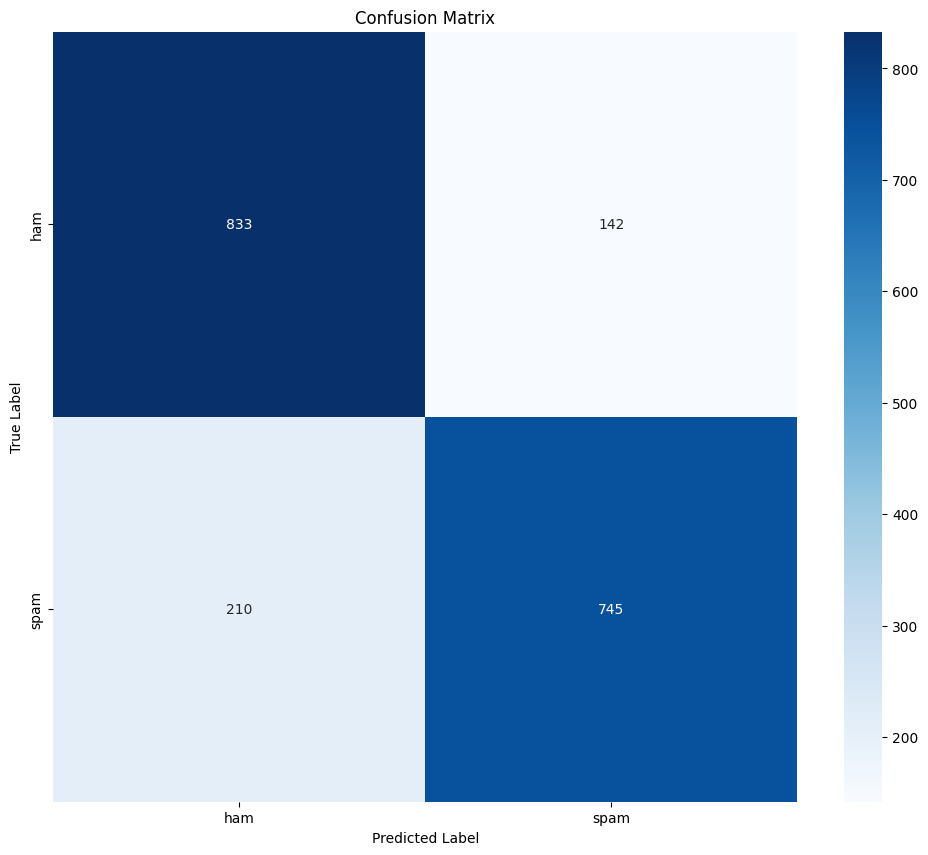

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.83       975
         1.0       0.84      0.78      0.81       955

    accuracy                           0.82      1930
   macro avg       0.82      0.82      0.82      1930
weighted avg       0.82      0.82      0.82      1930



In [58]:
evaluate_model(my_model.model, SMSSpamCollection_tf_data_valid, lb.classes_)

---
#### Setelah melalui Stopword removal model mengalami penurunan akurasi, dengan menunjukkan bahwa 833 dari 971 pesan reguler (ham) diklasifikasikan dengan benar, sementara 745 dari 956 pesan spam diklasifikasikan dengan benar. Dengan kata lain dengan menerapkan stop word removal pada jumlah perhitungan kata dalam suatu kalimat spam atau bukan tidak membantu akurasi.
---

## Part-of-Speech Tagging

Bahasa memiliki struktur tata bahasa. Dalam banyak bahasa, kata-kata dapat dikategorikan terutama menjadi kata kerja, kata keterangan, kata benda, dan kata sifat. Tujuan dari langkah pemrosesan ini adalah untuk mengambil sepotong teks dan memberi tag pada setiap token kata dengan pengenal POS (Part-of-Speech). Ini hanya masuk akal dalam kasus token tingkat kata.

Biasanya, Penn Treebank POS tagger digunakan oleh perpustakaan termasuk StanfordNLP untuk memberi tag pada kata-kata. Secara konvensional, tag POS ditambahkan dengan menggunakan kode setelah kata, dipisahkan oleh garis miring. Sebagai contoh, NNS adalah tag untuk kata benda jamak. Jika kata "goats" ditemukan, itu akan diwakili sebagai "goats/NNS". Dalam perpustakaan StandfordNLP, Universal POS (UPOS) tags digunakan. Berikut adalah tabel dari tag UPOS yang paling umum:

| Tag    | Kelas     | Contoh                |
|--------|-----------|-----------------------|
| ADJ    | Adjektiva | besar, cepat          |
| ADP    | Adposisi  | di, dengan            |
| ADV    | Adverbia  | sangat, cepat          |
| AUX    | Auksilier | telah, akan           |
| CCONJ  | Konjungsi Koordinatif | dan, atau  |
| INTJ   | Interjeksi| oh, wow               |
| NOUN   | Nomina    | buku, rumah           |
| NUM    | Numeralia | satu, dua             |
| DET    | Determiner| ini, itu              |
| PART   | Partikel  | lah, pun              |
| PRON   | Pronomina | saya, kamu            |
| PROPN  | Nama Diri | Jakarta, John         |
| PUNCT  | Tanda Baca| ., !                  |
| SCONJ  | Konjungsi Subordinatif | karena, jika|
| SYM    | Simbol    | $, %, +               |
| VERB   | Verba     | makan, tidur          |
| X      | Lainnya   | e.g., etc.            |

#### Penjelasan

Bayangkan kamu sedang membaca sebuah cerita dan ingin tahu fungsi setiap kata dalam kalimat. Misalnya:

- **ADJ (Adjektiva)**: Kata sifat yang menggambarkan sesuatu. Contoh: "besar", "cepat".
- **ADP (Adposisi)**: Kata yang menunjukkan hubungan antara kata benda lainnya. Contoh: "di", "dengan".
- **ADV (Adverbia)**: Kata keterangan yang menjelaskan bagaimana sesuatu dilakukan. Contoh: "sangat", "cepat".
- **AUX (Auksilier)**: Kata bantu yang membantu kata kerja utama. Contoh: "telah", "akan".
- **CCONJ (Konjungsi Koordinatif)**: Kata penghubung yang menghubungkan dua bagian kalimat yang setara. Contoh: "dan", "atau".
- **INTJ (Interjeksi)**: Kata seru yang mengekspresikan emosi. Contoh: "oh", "wow".
- **NOUN (Nomina)**: Kata benda yang menyebutkan orang, tempat, atau benda. Contoh: "buku", "rumah".
- **NUM (Numeralia)**: Angka atau jumlah. Contoh: "satu", "dua".
- **DET (Determiner)**: Kata penentu yang menunjukkan spesifik atau umum dari suatu benda. Contoh: "ini", "itu".
- **PART (Partikel)**: Kata kecil yang sering digunakan untuk menekankan atau menghubungkan kalimat. Contoh: "lah", "pun".
- **PRON (Pronomina)**: Kata ganti yang menggantikan nama orang atau benda. Contoh: "saya", "kamu".
- **PROPN (Nama Diri)**: Nama khusus untuk orang atau tempat tertentu. Contoh: "Jakarta", "John".
- **PUNCT (Tanda Baca)**: Tanda baca seperti titik atau tanda seru. Contoh: ".", "!".
- **SCONJ (Konjungsi Subordinatif)**: Kata penghubung yang menghubungkan kalimat utama dengan kalimat subordinat. Contoh: "karena", "jika".
- **SYM (Simbol)**: Simbol matematika atau lainnya. Contoh: "$", "%", "+".
- **VERB (Verba)**: Kata kerja yang menunjukkan tindakan atau keadaan. Contoh: "makan", "tidur".
- **X (Lainnya)**: Kategori lain yang tidak termasuk dalam kategori di atas.

In [59]:
txt = "Yo you around? A friend of mine's lookin."
doc = EN_NLP(txt)

for sentence in doc.sents:
    for word in sentence:
        if word.pos_ not in ['PUNCT', 'SYM']:
            print(f'{word}:\t {word.pos_}')

Yo:	 VERB
you:	 PRON
around:	 ADV
A:	 DET
friend:	 NOUN
of:	 ADP
mine:	 NOUN
's:	 PART
lookin:	 NOUN


Sekarang kita akan melanjutkan pembahasan tentang Part-of-Speech (POS) tagging. Bayangkan kita sedang mencoba memahami bagaimana komputer bisa mengerti teks seperti kita membaca buku.

#### Ketidaksempurnaan Model
Pertama, penting untuk diingat bahwa model seperti Spacy tidak selalu sempurna. Misalnya, kata "lookin" bisa saja dikategorikan sebagai kata benda (noun) padahal seharusnya bukan. Ini adalah hal yang wajar dan perlu kita perhatikan saat membangun model menggunakan fitur-fitur ini.

#### Fitur Tambahan dari POS Tagging
Ada beberapa fitur tambahan yang bisa kita buat menggunakan POS tagging:

1. **Menghitung Kata Tanpa Tanda Baca**:
   - Saat ini, metode `word_counts()` menghitung semua kata tanpa memperhatikan tanda baca. Kita bisa memperbarui metode ini agar tidak menghitung tanda baca sebagai kata.

2. **Proporsi Elemen Gramatikal**:
   - Kita bisa membuat fitur yang melihat proporsi berbagai jenis elemen gramatikal dalam pesan. Misalnya, berapa banyak kata kerja, kata benda, atau tanda baca dalam sebuah pesan.

3. **Hipotesis Spam**:
   - Salah satu hipotesis yang bisa kita uji adalah apakah pesan spam menggunakan lebih banyak tanda baca dan simbol. Kita bisa menambahkan fitur untuk menunjukkan persentase simbol dan tanda baca dalam sebuah pesan.

#### Langkah Selanjutnya
Sebagai langkah berikutnya, mari kita perbarui metode `word_counts()` dan tambahkan fitur untuk menunjukkan persentase simbol dan tanda baca dalam sebuah pesan. Fitur-fitur lain terkait jenis elemen gramatikal juga bisa dibuat, dan ini adalah tugas yang bisa kamu coba implementasikan sendiri.

In [64]:
df_copy = df.copy(deep=True)
lb = LabelBinarizer()

df_copy['label'] = lb.fit_transform(df_copy['label'])
df_copy['capitals'] = df_copy['message'].apply(num_capitals)
df_copy['punctuation'] = df_copy['message'].apply(num_punctuation)
df_copy['length'] = df_copy['message'].apply(message_length)
df_copy['words'] = df_copy['message'].apply(lambda text: word_counts_v2(text, EN_NLP, EN_SW))

results = df_copy['message'].apply(lambda text: word_counts_no_punct(text, pipeline=EN_NLP, stopwords=EN_SW))
df_copy['words_nopunct'], df_copy['punct_proportion'] = zip(*results)

In [74]:
df_copy[:5]

,label,message,capitals,punctuation,length,words,words_nopunct,punct_proportion
0,0,"Go until jurong point, crazy.. Available only ...",3,9,111,11,7,0.166667
1,0,Ok lar... Joking wif u oni...,2,6,29,6,4,0.250000
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,10,6,155,23,22,0.032258
3,0,U dun say so early hor... U c already then say...,2,6,49,4,2,0.153846
4,0,"Nah I don't think he goes to usf, he lives aro...",2,2,61,5,4,0.066667


In [75]:
print('Ham dataframe statistic')
df_copy[df_copy['label'] == 0].describe()

Ham dataframe statistic


,label,capitals,punctuation,length,words,words_nopunct,punct_proportion
count,4825.0,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000
mean,0.0,4.110466,3.928705,71.482487,7.933886,5.536580,0.136657
std,0.0,10.848116,4.692083,58.440652,7.368244,5.077464,0.089366
min,0.0,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,0.0,1.000000,1.000000,33.000000,4.000000,2.000000,0.083333
50%,0.0,2.000000,3.000000,52.000000,6.000000,4.000000,0.133333
75%,0.0,3.000000,5.000000,93.000000,10.000000,7.000000,0.181818
max,0.0,138.000000,133.000000,910.000000,147.000000,72.000000,1.000000


In [76]:
print('Spam dataframe statistic')
df_copy[df_copy['label'] == 1].describe()

Spam dataframe statistic


,label,capitals,punctuation,length,words,words_nopunct,punct_proportion
count,747.0,747.00000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,1.0,15.46988,5.499331,138.670683,18.248996,14.127175,0.137495
std,0.0,12.30576,3.374870,28.873603,6.094617,4.693118,0.070607
min,1.0,0.00000,0.000000,13.000000,2.000000,2.000000,0.000000
25%,1.0,7.00000,3.000000,133.000000,14.000000,11.000000,0.093750
50%,1.0,14.00000,5.000000,149.000000,18.000000,14.000000,0.133333
75%,1.0,21.00000,8.000000,157.000000,22.500000,17.000000,0.181818
max,1.0,128.00000,25.000000,223.000000,38.000000,29.000000,0.454545


In [77]:
X = df_copy.drop(columns=['label', 'message'])
y = df_copy['label']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

SMSSpamCollection_tf_data = tf.data.Dataset.from_tensor_slices((X_resampled, y_resampled))

SMSSpamCollection_tf_data_scaled = SMSSpamCollection_tf_data.map( 
    map_func=lambda features, label: minmax_scaling_tf(features, label, feature_range=(0, 1)),
    num_parallel_calls=tf.data.AUTOTUNE
)
SMSSpamCollection_tf_data_cached = SMSSpamCollection_tf_data_scaled.cache()

splitter = DatasetSplitter(batch_size=32, train_split=0.8)

SMSSpamCollection_tf_data_train, SMSSpamCollection_tf_data_valid = splitter.split_and_prepare(SMSSpamCollection_tf_data_cached)

=================================== Training Dataset ===================================
Info data: <_TakeDataset element_spec=(TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
Training Split: 0.8
Number of data: 7720
AFTER BATCH: 32
Number of data: 242
=================================== Validation Dataset ===================================
Info data: <_SkipDataset element_spec=(TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
Validation Split: 0.2
Number of data: 1930
AFTER BATCH: 32
Number of data: 61


In [89]:
my_model=SpamLDetectionModel(
    input_shape=INPUT_SHAPE_MODEL_V4, 
    num_classes=NUM_LABEL, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=LOSS,
    metrics=METRICS
)
my_model.model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

In [90]:
history = my_model.train(
    SMSSpamCollection_tf_data_train,
    validation_data=SMSSpamCollection_tf_data_valid,
    epochs=30,
)

Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5454 - loss: 0.6914 - val_accuracy: 0.5161 - val_loss: 0.6798
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7252 - loss: 0.6752 - val_accuracy: 0.7865 - val_loss: 0.6591
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7718 - loss: 0.6555 - val_accuracy: 0.7870 - val_loss: 0.6320
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7854 - loss: 0.6224 - val_accuracy: 0.7813 - val_loss: 0.6040
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8021 - loss: 0.5903 - val_accuracy: 0.7938 - val_loss: 0.5773
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7932 - loss: 0.5630 - val_accuracy: 0.7865 - val_loss: 0.5582
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8101 - loss: 0.5378 - val_accuracy: 0.8052 - val_loss: 0.5347
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8079 - loss: 0.5232 - val_accuracy: 0.

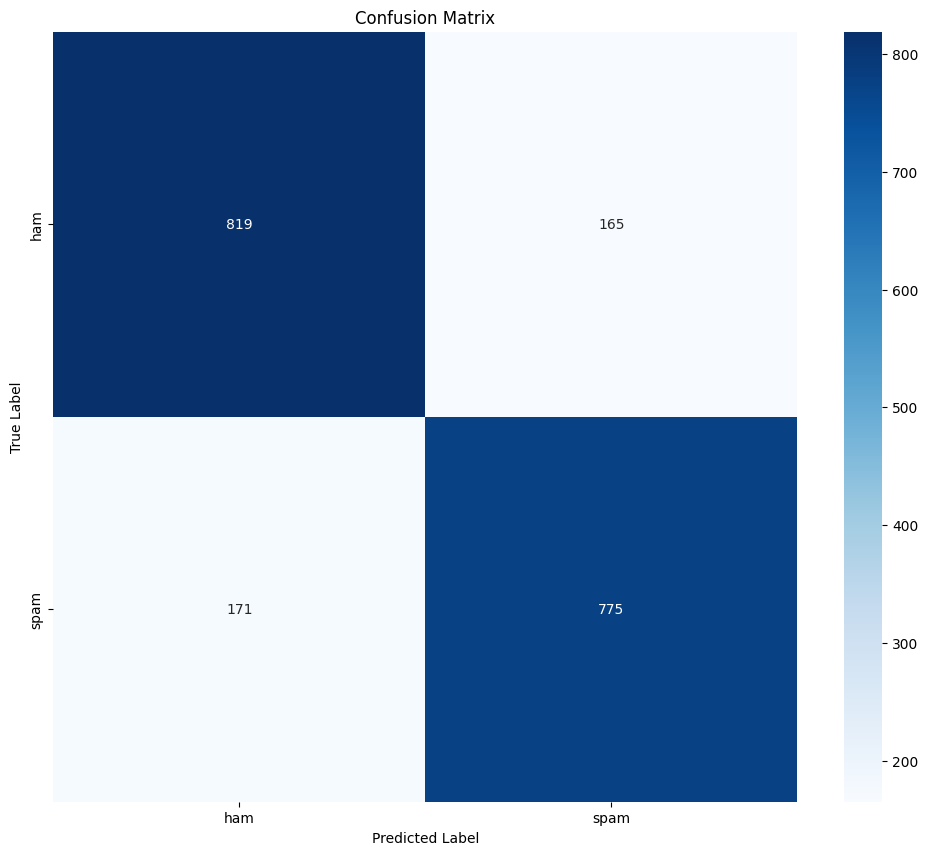

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       984
         1.0       0.82      0.82      0.82       946

    accuracy                           0.83      1930
   macro avg       0.83      0.83      0.83      1930
weighted avg       0.83      0.83      0.83      1930



In [85]:
evaluate_model(my_model.model, SMSSpamCollection_tf_data_valid, lb.classes_)

---
#### Setelah melalui Stopword removal model mengalami sedikit peningkatan akurasi, dengan menunjukkan bahwa 819 dari 971 pesan reguler (ham) diklasifikasikan dengan benar, sementara 775 dari 956 pesan spam diklasifikasikan dengan benar. Dengan kata lain dengan menerapkan POS tagging pada jumlah perhitungan kata dalam suatu kalimat spam atau bukan sedikit membantu akurasi.
---

## Stemming dan Lemmatization

#### Apa itu Stemming dan Lemmatization?

Dalam pemrosesan bahasa alami (Natural Language Processing atau NLP), kita sering menemui kata-kata yang memiliki berbagai bentuk tergantung pada penggunaannya. Misalnya, kata "depend" memiliki bentuk lain seperti "depends", "depending", "depended", dan "dependent". Variasi ini bisa disebabkan oleh perubahan waktu (tenses) atau bentuk kata lainnya.

Untuk mengatasi variasi ini dan membuat analisis teks lebih efisien, kita menggunakan dua teknik utama: **stemming** dan **lemmatization**.

#### Stemming

**Stemming** adalah proses menghilangkan akhiran (suffix) dari kata untuk mendapatkan bentuk dasarnya. Teknik ini menggunakan aturan sederhana dan sering kali menghasilkan kata yang tidak selalu merupakan kata yang benar dalam bahasa tersebut. Contoh paling terkenal adalah **Porter Stemmer**, yang dikembangkan oleh Martin Porter pada tahun 1980.

Contoh:
- Kata "running" setelah stemming menjadi "run".
- Kata "happiness" setelah stemming menjadi "happi".

Kalimat asli: 
"Stemming is aimed at reducing vocabulary and aid understanding of morphological processes."

Setelah stemming dengan Porter Stemmer:
"Stem is aim at reduc vocabulari and aid understand of morpholog process."

#### Lemmatization

**Lemmatization** adalah proses yang lebih canggih dibandingkan stemming. Teknik ini menggunakan kamus dan analisis morfologi untuk mengubah kata ke bentuk dasarnya yang benar, yang disebut **lemma**. Lemmatization mempertimbangkan konteks dan bagian dari kata (part of speech) untuk menghasilkan kata dasar yang benar.

Contoh:
- Kata "running" setelah lemmatization menjadi "run".
- Kata "better" setelah lemmatization menjadi "good".

Kalimat asli: 
"Lemmatization approaches this task in a more sophisticated manner, using vocabularies and morphological analysis of words."

Setelah lemmatization:
"Lemmatization approach this task in a more sophisticated manner, use vocabulary and morphological analysis of word."

#### Mengapa Ini Penting?

Dengan menggunakan stemming atau lemmatization, kita bisa mengurangi ukuran kosakata yang perlu dianalisis dan meningkatkan akurasi pencocokan kata dalam dokumen. Misalnya, dalam bahasa Rusia, kata "London" bisa memiliki bentuk berbeda tergantung pada penggunaannya dalam kalimat. Dengan normalisasi menggunakan stemming atau lemmatization, semua bentuk kata "London" bisa dikenali sebagai satu entitas yang sama.

#### Kesimpulan

- **Stemming**: Teknik sederhana yang menghilangkan akhiran kata. Contoh: "running" menjadi "run".
- **Lemmatization**: Teknik canggih yang mengubah kata ke bentuk dasarnya yang benar dengan mempertimbangkan konteks. Contoh: "better" menjadi "good".

Kedua teknik ini membantu dalam mengurangi ukuran kosakata dan meningkatkan pemahaman teks dalam analisis bahasa alami.

In [86]:
text = "Stemming is aimed at reducing vocabulary and aid un-derstanding of" +\
       " morphological processes. This helps people un-derstand the" +\
       " morphology of words and reduce size of corpus."

doc = EN_NLP(text) 

lemma = ""
for sentence in doc.sents:
    for word in sentence:
        lemma += f"{word.lemma_}/{word.pos_}\t"
        print(f'{word}: --> : {word.lemma_}')
    lemma += f"\n"
print()
print(lemma)

Stemming: --> : stemming
is: --> : be
aimed: --> : aim
at: --> : at
reducing: --> : reduce
vocabulary: --> : vocabulary
and: --> : and
aid: --> : aid
un: --> : un
-: --> : -
derstanding: --> : derstanding
of: --> : of
morphological: --> : morphological
processes: --> : process
.: --> : .
This: --> : this
helps: --> : help
people: --> : people
un: --> : un
-: --> : -
derstand: --> : derstand
the: --> : the
morphology: --> : morphology
of: --> : of
words: --> : word
and: --> : and
reduce: --> : reduce
size: --> : size
of: --> : of
corpus: --> : corpus
.: --> : .

stemming/NOUN	be/AUX	aim/VERB	at/ADP	reduce/VERB	vocabulary/NOUN	and/CCONJ	aid/VERB	un/NOUN	-/NOUN	derstanding/NOUN	of/ADP	morphological/ADJ	process/NOUN	./PUNCT	
this/PRON	help/VERB	people/NOUN	un/PROPN	-/NOUN	derstand/VERB	the/DET	morphology/NOUN	of/ADP	word/NOUN	and/CCONJ	reduce/VERB	size/NOUN	of/ADP	corpus/PROPN	./PUNCT	



Setelah normalisasi teks selesai, kita dapat memulai vektorisasi teks. 